In [3]:
import os
import numpy as np
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Parámetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 20

SEED = 42

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Usando GPU: {physical_devices}")
    except Exception as e:
        print(f"Error configurando GPU: {e}")
else:
    print("No se detectó GPU, usando CPU.")


Usando GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [71]:
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments

def load_images_from_directory(directory):
    data_gen = ImageDataGenerator(rescale=1.0/255.0)  # Sin validation_split

    train_data = data_gen.flow_from_directory(
        directory,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    return train_data

image_directory = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_labrax\train"
train_data = load_images_from_directory(image_directory)

processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch32-224-in21k",  # Cambia a la variante VITB-32
    do_rescale=False
)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch32-224-in21k",  # Cambia a la variante VITB-32
    num_labels=len(train_data.class_indices),
    id2label={v: k for k, v in train_data.class_indices.items()},
    label2id={k: v for k, v in train_data.class_indices.items()}
)

def preprocess_data(data_generator):
    images = []
    labels = []
    for i in range(len(data_generator)):
        batch_images, batch_labels = data_generator[i]
        for img, label in zip(batch_images, batch_labels):
            processed_img = processor(images=img, return_tensors="pt")['pixel_values'][0]
            images.append(processed_img)
            labels.append(np.argmax(label)) 
    return torch.stack(images), torch.tensor(labels)

train_images, train_labels = preprocess_data(train_data)

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {"pixel_values": self.images[idx], "labels": self.labels[idx]}

dataset = ImageDataset(train_images, train_labels)
train_dataset = dataset

training_args = TrainingArguments(
    output_dir="./vit_fish_model",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=processor, 
    data_collator=None,
)

trainer.train()

Found 1316 images belonging to 2 classes.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/420 [00:00<?, ?it/s]

{'train_runtime': 914.0928, 'train_samples_per_second': 28.794, 'train_steps_per_second': 0.459, 'train_loss': 0.03288232258387974, 'epoch': 20.0}


TrainOutput(global_step=420, training_loss=0.03288232258387974, metrics={'train_runtime': 914.0928, 'train_samples_per_second': 28.794, 'train_steps_per_second': 0.459, 'total_flos': 2.0789682671665152e+18, 'train_loss': 0.03288232258387974, 'epoch': 20.0})

Found 287 images belonging to 2 classes.
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           C       0.97      0.93      0.95       211
           S       0.83      0.92      0.88        76

    accuracy                           0.93       287
   macro avg       0.90      0.93      0.91       287
weighted avg       0.93      0.93      0.93       287



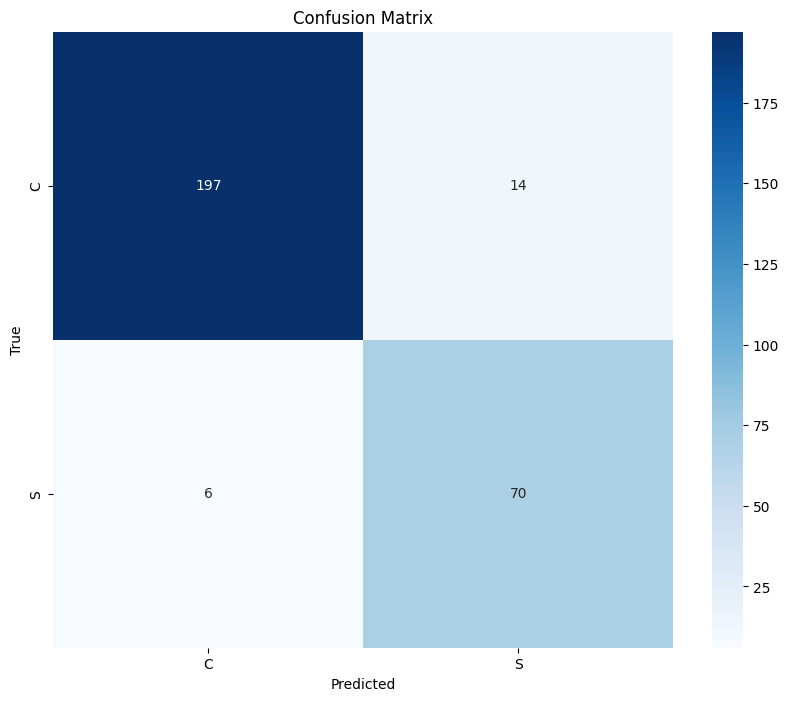

In [72]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesar los datos de prueba (similar a preprocess_data)
def preprocess_test_data(data_generator):
    images = []
    labels = []
    for i in range(len(data_generator)):
        batch_images, batch_labels = data_generator[i]
        for img, label in zip(batch_images, batch_labels):
            processed_img = processor(images=img, return_tensors="pt")['pixel_values'][0]
            images.append(processed_img)
            labels.append(np.argmax(label))
    return torch.stack(images), torch.tensor(labels)

# Directorio del conjunto de prueba
test_directory = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_labrax\test"
test_data = load_images_from_directory(test_directory)

# Preprocesar los datos de prueba
test_images, test_labels = preprocess_test_data(test_data)

# Convertir a dataset
test_dataset = ImageDataset(test_images, test_labels)

# Predicciones del modelo
model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    for batch in test_dataset:
        outputs = model(pixel_values=batch["pixel_values"].unsqueeze(0))
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()
        predictions.append(pred)
        true_labels.append(batch["labels"].item())

# Métricas de evaluación
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Reporte de clasificación
class_report = classification_report(true_labels, predictions, target_names=list(test_data.class_indices.keys()))
print("Classification Report:\n", class_report)

# Matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_data.class_indices.keys()), yticklabels=list(test_data.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

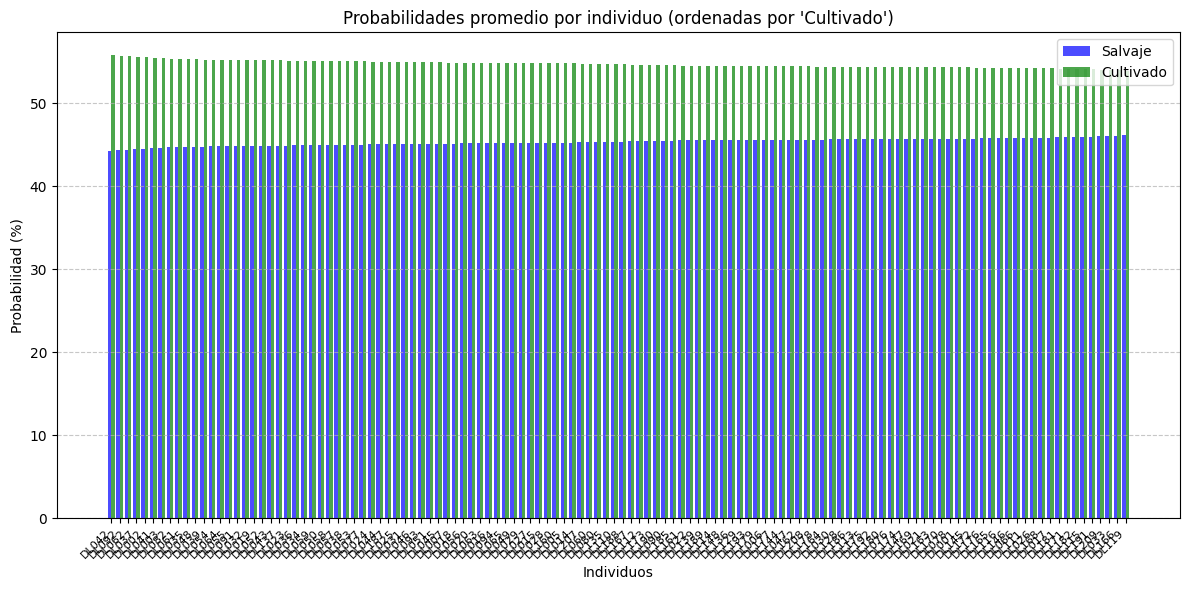

Probabilidad total de 'Salvaje': 45.31%
Probabilidad total de 'Cultivado': 54.69%


In [73]:
import os
import numpy as np
import torch
from PIL import Image
from scipy.special import softmax
from collections import defaultdict
import matplotlib.pyplot as plt

#  Ruta de las imágenes e inicialización
images_folder = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\E"

# Configuración del tamaño de imagen esperado
image_size = (224, 224)  # Tamaño esperado por ViT

def preprocess_image(image_path, processor):
    """Preprocesa una imagen para que sea compatible con el modelo ViT."""
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")
    return inputs['pixel_values']

def get_individual_name(file_name):
    """Extraer el identificador del individuo del nombre del archivo."""
    return file_name.split('(')[0].strip()

# Procesar todas las imágenes y agrupar por individuo
results = defaultdict(list)  # Diccionario para almacenar probabilidades por individuo
image_groups = defaultdict(list)  # Diccionario para agrupar nombres de archivos por individuo

for file_name in sorted(os.listdir(images_folder)):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        individual_name = get_individual_name(file_name)  # Identificar individuo
        image_path = os.path.join(images_folder, file_name)
        processed_img = preprocess_image(image_path, processor)

        with torch.no_grad():
            logits = model(processed_img).logits  # Obtener logits
        probabilities = softmax(logits.numpy()[0])  # Convertir logits a probabilidades

        results[individual_name].append(probabilities)  # Agrupar por individuo
        image_groups[individual_name].append(file_name)  # Almacenar nombres

# Calcular promedio de probabilidades por individuo
individual_averages = {ind: np.mean(probs, axis=0) for ind, probs in results.items()}
sorted_individuals = sorted(individual_averages.items(), key=lambda x: x[1][1], reverse=True)

# Separar nombres y probabilidades ya ordenados
individual_names = [ind for ind, _ in sorted_individuals]
wild_probabilities = [probs[0] * 100 for _, probs in sorted_individuals]  # Salvaje (%)
cultivated_probabilities = [probs[1] * 100 for _, probs in sorted_individuals]  # Cultivado (%)

# Graficar resultados agrupados por individuo (ordenados)
x = np.arange(len(sorted_individuals))  # Índices de individuos
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, wild_probabilities, width=0.4, label="Salvaje", color='blue', alpha=0.7)
plt.bar(x + 0.2, cultivated_probabilities, width=0.4, label="Cultivado", color='green', alpha=0.7)
plt.xticks(x, individual_names, rotation=45, ha='right', fontsize=8)
plt.ylabel("Probabilidad (%)")
plt.xlabel("Individuos")
plt.title("Probabilidades promedio por individuo (ordenadas por 'Cultivado')")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla para claridad
plt.show()

# Calcular probabilidades totales
total_wild = sum(probs[0] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Salvaje (%)
total_cultivated = sum(probs[1] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Cultivado (%)

print(f"Probabilidad total de 'Salvaje': {total_wild:.2f}%")
print(f"Probabilidad total de 'Cultivado': {total_cultivated:.2f}%")


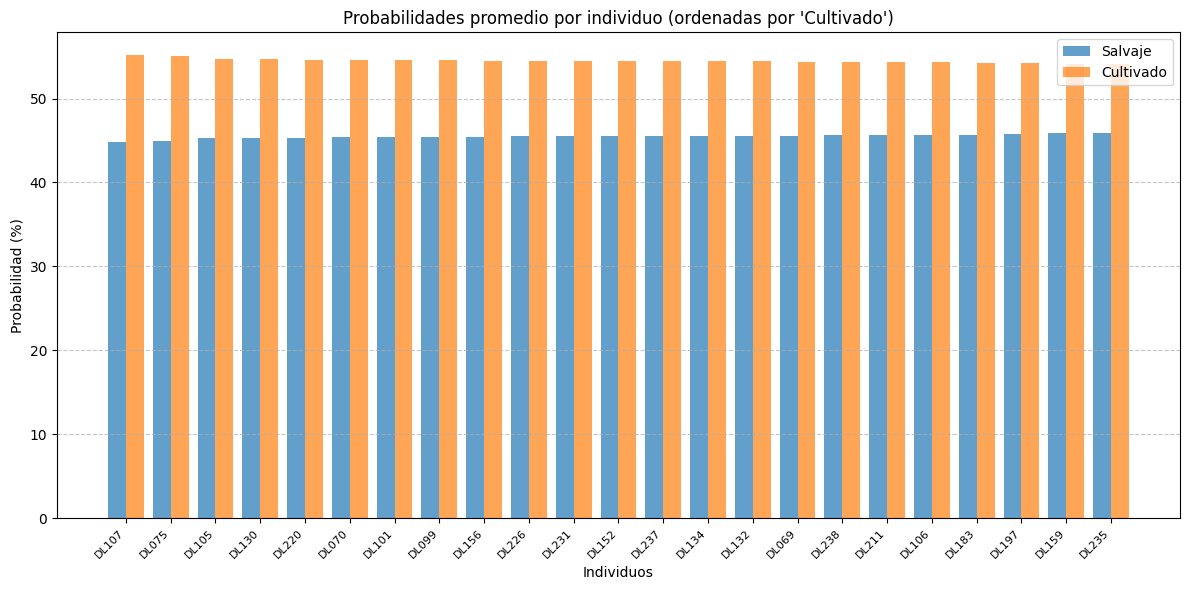

Probabilidad total de 'Salvaje': 45.48%
Probabilidad total de 'Cultivado': 54.52%


In [74]:
import os
import numpy as np
import torch
from PIL import Image
from scipy.special import softmax
from collections import defaultdict
import matplotlib.pyplot as plt

# Ruta de las imágenes
images_folders = [
    r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\test\C",
    r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\test\S"
]

# Configuración del tamaño de imagen esperado
image_size = (224, 224)  # Tamaño esperado por ViT

# Función para preprocesar una imagen
def preprocess_image(image_path, processor):
    """Preprocesa una imagen para que sea compatible con el modelo ViT."""
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")
    return inputs['pixel_values']

# Función para extraer el identificador del individuo
def get_individual_name(file_name):
    """Extraer el identificador del individuo del nombre del archivo."""
    return file_name.split('(')[0].strip()

# Inicializar resultados
results = defaultdict(list)  # Diccionario para almacenar probabilidades por individuo
image_groups = defaultdict(list)  # Diccionario para agrupar nombres de archivos por individuo

# Procesar todas las imágenes en las carpetas
for folder in images_folders:
    for file_name in sorted(os.listdir(folder)):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            individual_name = get_individual_name(file_name)  # Identificar individuo
            image_path = os.path.join(folder, file_name)
            processed_img = preprocess_image(image_path, processor)

            # Calcular logits y probabilidades
            with torch.no_grad():
                logits = model(processed_img).logits  # Obtener logits
            probabilities = softmax(logits.numpy()[0])  # Convertir logits a probabilidades

            # Guardar resultados
            results[individual_name].append(probabilities)  # Agrupar por individuo
            image_groups[individual_name].append(file_name)  # Almacenar nombres

# Calcular promedio de probabilidades por individuo
individual_averages = {ind: np.mean(probs, axis=0) for ind, probs in results.items()}
sorted_individuals = sorted(individual_averages.items(), key=lambda x: x[1][1], reverse=True)

# Separar nombres y probabilidades ya ordenados
individual_names = [ind for ind, _ in sorted_individuals]
wild_probabilities = [probs[0] * 100 for _, probs in sorted_individuals]  # Salvaje (%)
cultivated_probabilities = [probs[1] * 100 for _, probs in sorted_individuals]  # Cultivado (%)

# Graficar resultados agrupados por individuo (ordenados)
x = np.arange(len(sorted_individuals))  # Índices de individuos
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, wild_probabilities, width=0.4, label="Salvaje", alpha=0.7)
plt.bar(x + 0.2, cultivated_probabilities, width=0.4, label="Cultivado", alpha=0.7)
plt.xticks(x, individual_names, rotation=45, ha='right', fontsize=8)
plt.ylabel("Probabilidad (%)")
plt.xlabel("Individuos")
plt.title("Probabilidades promedio por individuo (ordenadas por 'Cultivado')")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla para claridad
plt.show()

# Calcular probabilidades totales
total_wild = sum(probs[0] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Salvaje (%)
total_cultivated = sum(probs[1] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Cultivado (%)

print(f"Probabilidad total de 'Salvaje': {total_wild:.2f}%")
print(f"Probabilidad total de 'Cultivado': {total_cultivated:.2f}%")


c:\Users\Tech4Diet\anaconda3\envs\clip_tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tech4Diet\anaconda3\envs\clip_tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tech4Diet\anaconda3\envs\clip_tf_env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

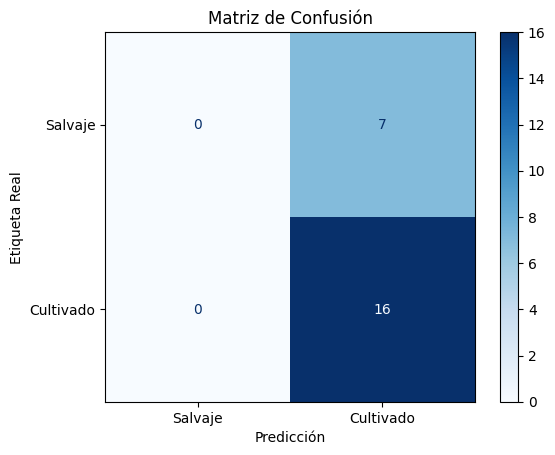

Accuracy: 0.70

Reporte de Clasificación:
              precision    recall  f1-score   support

     Salvaje       0.00      0.00      0.00         7
   Cultivado       0.70      1.00      0.82        16

    accuracy                           0.70        23
   macro avg       0.35      0.50      0.41        23
weighted avg       0.48      0.70      0.57        23



In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

def extract_class_from_filename(file_name):
    """
    Extrae la clase ('_S' o '_C') del nombre del archivo.
    - '_S' representa 'Salvaje' (0).
    - '_C' representa 'Cultivado' (1).
    """
    if "_S" in file_name:
        return 0  # Salvaje
    elif "_C" in file_name:
        return 1  # Cultivado
    else:
        raise ValueError(f"No se pudo determinar la clase del archivo: {file_name}")

# Inicializar listas para etiquetas reales y predicciones
true_labels = []
predictions = []

# Procesar individuos y calcular predicciones
for individual_name, probs_list in results.items():
    try:
        # Etiqueta real extraída del nombre de la primera imagen del grupo
        true_label = extract_class_from_filename(image_groups[individual_name][0])
    except ValueError as e:
        print(e)  # Mostrar error si no se encuentra la clase
        continue  # Saltar al siguiente individuo

    # Promedio de probabilidades para este individuo
    avg_probs = np.mean(probs_list, axis=0)

    # Predicción: índice con la mayor probabilidad
    predicted_label = np.argmax(avg_probs)

    # Guardar etiquetas reales y predicciones
    true_labels.append(true_label)
    predictions.append(predicted_label)

# Calcular métricas
accuracy = accuracy_score(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions, target_names=["Salvaje", "Cultivado"])

# Crear matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Salvaje", "Cultivado"])
disp.plot(cmap="Blues", values_format="d")

# Configurar y mostrar la matriz de confusión
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.grid(False)  # Quitar rejilla
plt.show()

# Mostrar métricas
print(f"Accuracy: {accuracy:.2f}")
print("\nReporte de Clasificación:")
print(classification_rep)


In [4]:
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments

def load_images_from_directory(directory):
    data_gen = ImageDataGenerator(rescale=1.0/255.0)  # Sin validation_split

    train_data = data_gen.flow_from_directory(
        directory,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )

    return train_data

image_directory = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_Aurata\train"
train_data = load_images_from_directory(image_directory)

processor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch32-224-in21k",  # Cambia a la variante VITB-32
    do_rescale=False
)
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch32-224-in21k",  # Cambia a la variante VITB-32
    num_labels=len(train_data.class_indices),
    id2label={v: k for k, v in train_data.class_indices.items()},
    label2id={k: v for k, v in train_data.class_indices.items()}
)

def preprocess_data(data_generator):
    images = []
    labels = []
    for i in range(len(data_generator)):
        batch_images, batch_labels = data_generator[i]
        for img, label in zip(batch_images, batch_labels):
            processed_img = processor(images=img, return_tensors="pt")['pixel_values'][0]
            images.append(processed_img)
            labels.append(np.argmax(label)) 
    return torch.stack(images), torch.tensor(labels)

train_images, train_labels = preprocess_data(train_data)

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {"pixel_values": self.images[idx], "labels": self.labels[idx]}

dataset = ImageDataset(train_images, train_labels)
train_dataset = dataset

training_args = TrainingArguments(
    output_dir="./vit_fish_model",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=processor, 
    data_collator=None,
)

trainer.train()

Found 1937 images belonging to 2 classes.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/620 [00:00<?, ?it/s]

{'loss': 0.0238, 'grad_norm': 0.032092347741127014, 'learning_rate': 9.67741935483871e-06, 'epoch': 16.13}
{'train_runtime': 1371.5989, 'train_samples_per_second': 28.244, 'train_steps_per_second': 0.452, 'train_loss': 0.019960485302632856, 'epoch': 20.0}


TrainOutput(global_step=620, training_loss=0.019960485302632856, metrics={'train_runtime': 1371.5989, 'train_samples_per_second': 28.244, 'train_steps_per_second': 0.452, 'total_flos': 3.0600011652747264e+18, 'train_loss': 0.019960485302632856, 'epoch': 20.0})

Found 583 images belonging to 2 classes.
Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           C       1.00      0.99      0.99       144
           S       1.00      1.00      1.00       439

    accuracy                           1.00       583
   macro avg       1.00      0.99      1.00       583
weighted avg       1.00      1.00      1.00       583



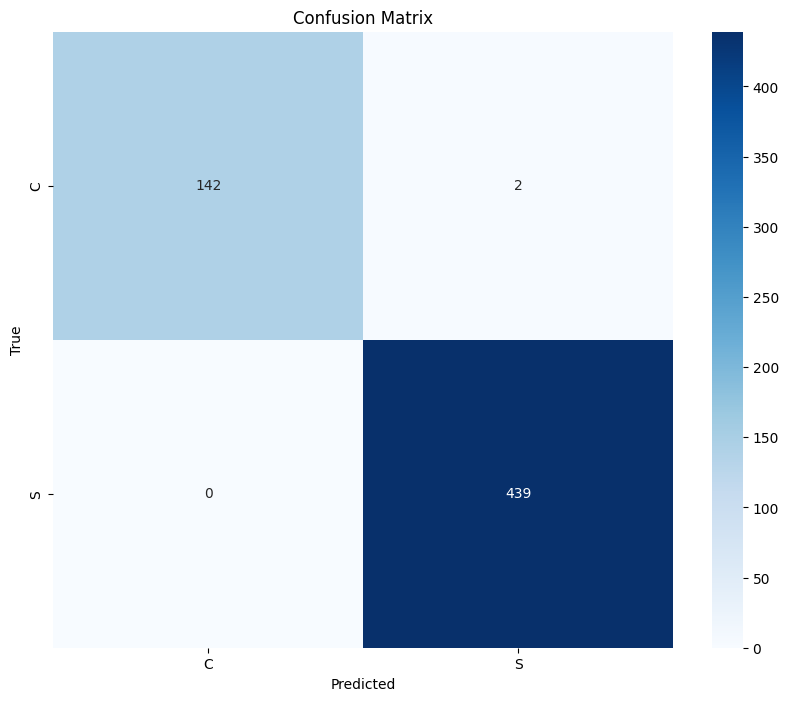

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesar los datos de prueba (similar a preprocess_data)
def preprocess_test_data(data_generator):
    images = []
    labels = []
    for i in range(len(data_generator)):
        batch_images, batch_labels = data_generator[i]
        for img, label in zip(batch_images, batch_labels):
            processed_img = processor(images=img, return_tensors="pt")['pixel_values'][0]
            images.append(processed_img)
            labels.append(np.argmax(label))
    return torch.stack(images), torch.tensor(labels)

# Directorio del conjunto de prueba
test_directory = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_Aurata\test"
test_data = load_images_from_directory(test_directory)

# Preprocesar los datos de prueba
test_images, test_labels = preprocess_test_data(test_data)

# Convertir a dataset
test_dataset = ImageDataset(test_images, test_labels)

# Predicciones del modelo
model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    for batch in test_dataset:
        outputs = model(pixel_values=batch["pixel_values"].unsqueeze(0))
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()
        predictions.append(pred)
        true_labels.append(batch["labels"].item())

# Métricas de evaluación
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Reporte de clasificación
class_report = classification_report(true_labels, predictions, target_names=list(test_data.class_indices.keys()))
print("Classification Report:\n", class_report)

# Matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(test_data.class_indices.keys()), yticklabels=list(test_data.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

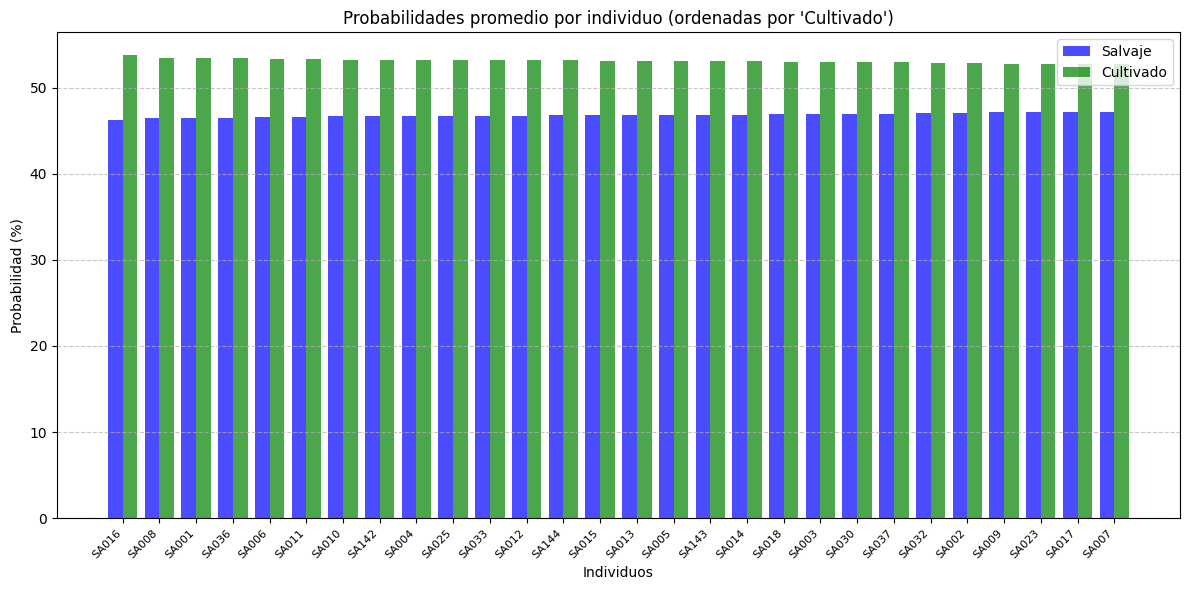

Probabilidad total de 'Salvaje': 46.83%
Probabilidad total de 'Cultivado': 53.17%


In [78]:
import os
import numpy as np
import torch
from PIL import Image
from scipy.special import softmax
from collections import defaultdict
import matplotlib.pyplot as plt

#  Ruta de las imágenes e inicialización
images_folder = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_Aurata\E"

# Configuración del tamaño de imagen esperado
image_size = (224, 224)  # Tamaño esperado por ViT

def preprocess_image(image_path, processor):
    """Preprocesa una imagen para que sea compatible con el modelo ViT."""
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")
    return inputs['pixel_values']

def get_individual_name(file_name):
    """Extraer el identificador del individuo del nombre del archivo."""
    return file_name.split('(')[0].strip()

# Procesar todas las imágenes y agrupar por individuo
results = defaultdict(list)  # Diccionario para almacenar probabilidades por individuo
image_groups = defaultdict(list)  # Diccionario para agrupar nombres de archivos por individuo

for file_name in sorted(os.listdir(images_folder)):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        individual_name = get_individual_name(file_name)  # Identificar individuo
        image_path = os.path.join(images_folder, file_name)
        processed_img = preprocess_image(image_path, processor)

        with torch.no_grad():
            logits = model(processed_img).logits  # Obtener logits
        probabilities = softmax(logits.numpy()[0])  # Convertir logits a probabilidades

        results[individual_name].append(probabilities)  # Agrupar por individuo
        image_groups[individual_name].append(file_name)  # Almacenar nombres

# Calcular promedio de probabilidades por individuo
individual_averages = {ind: np.mean(probs, axis=0) for ind, probs in results.items()}
sorted_individuals = sorted(individual_averages.items(), key=lambda x: x[1][1], reverse=True)

# Separar nombres y probabilidades ya ordenados
individual_names = [ind for ind, _ in sorted_individuals]
wild_probabilities = [probs[0] * 100 for _, probs in sorted_individuals]  # Salvaje (%)
cultivated_probabilities = [probs[1] * 100 for _, probs in sorted_individuals]  # Cultivado (%)

# Graficar resultados agrupados por individuo (ordenados)
x = np.arange(len(sorted_individuals))  # Índices de individuos
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, wild_probabilities, width=0.4, label="Salvaje", color='blue', alpha=0.7)
plt.bar(x + 0.2, cultivated_probabilities, width=0.4, label="Cultivado", color='green', alpha=0.7)
plt.xticks(x, individual_names, rotation=45, ha='right', fontsize=8)
plt.ylabel("Probabilidad (%)")
plt.xlabel("Individuos")
plt.title("Probabilidades promedio por individuo (ordenadas por 'Cultivado')")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla para claridad
plt.show()

# Calcular probabilidades totales
total_wild = sum(probs[0] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Salvaje (%)
total_cultivated = sum(probs[1] for probs in individual_averages.values()) * 100 / len(individual_averages)  # Cultivado (%)

print(f"Probabilidad total de 'Salvaje': {total_wild:.2f}%")
print(f"Probabilidad total de 'Cultivado': {total_cultivated:.2f}%")
